# Effective depth results across models

Here we analyze and plot the results of effective depth across different models. We follow "Do Language Models Use Their Depth Efficiently?" by Csordás et al. (2025) and use the following metrics:
1. Relative norm contribution & cosine similarity
2. The effects of the layer on future computations
3. Logit lens overlap
4. Residual erasure experiment
5. Integrated gradients

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
models = [
    # deepseek models
    "DeepSeek-R1-Distill-Qwen-1.5B",
    "DeepSeek-R1-Distill-Qwen-7B",
    "DeepSeek-R1-Distill-Qwen-14B",
    "DeepSeek-R1-Distill-Qwen-32B",
    
    # qwen models
    "Qwen2.5-1.5B-Instruct",
    "Qwen2.5-7B-Instruct",
    "Qwen2.5-14B-Instruct",
    "Qwen2.5-32B-Instruct",
    "Qwen2.5-Math-1.5B",
    "Qwen2.5-Math-7B",
    "Qwen2.5-14B",
    "Qwen2.5-32B"
]

In [3]:
task = "gsm8k"

## 1. relative norm contribution & cosine similarity

In [4]:
def sort_zorder(bars):
    for group in zip(*[container for container in bars]):
        # 'group' is a tuple of bar objects at one x position from different groups.
        z = len(group)
        # Sort the bars by height (lowest first).
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1

In [ ]:
plt.rcParams['font.family'] = ['DejaVu Serif']
# plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'

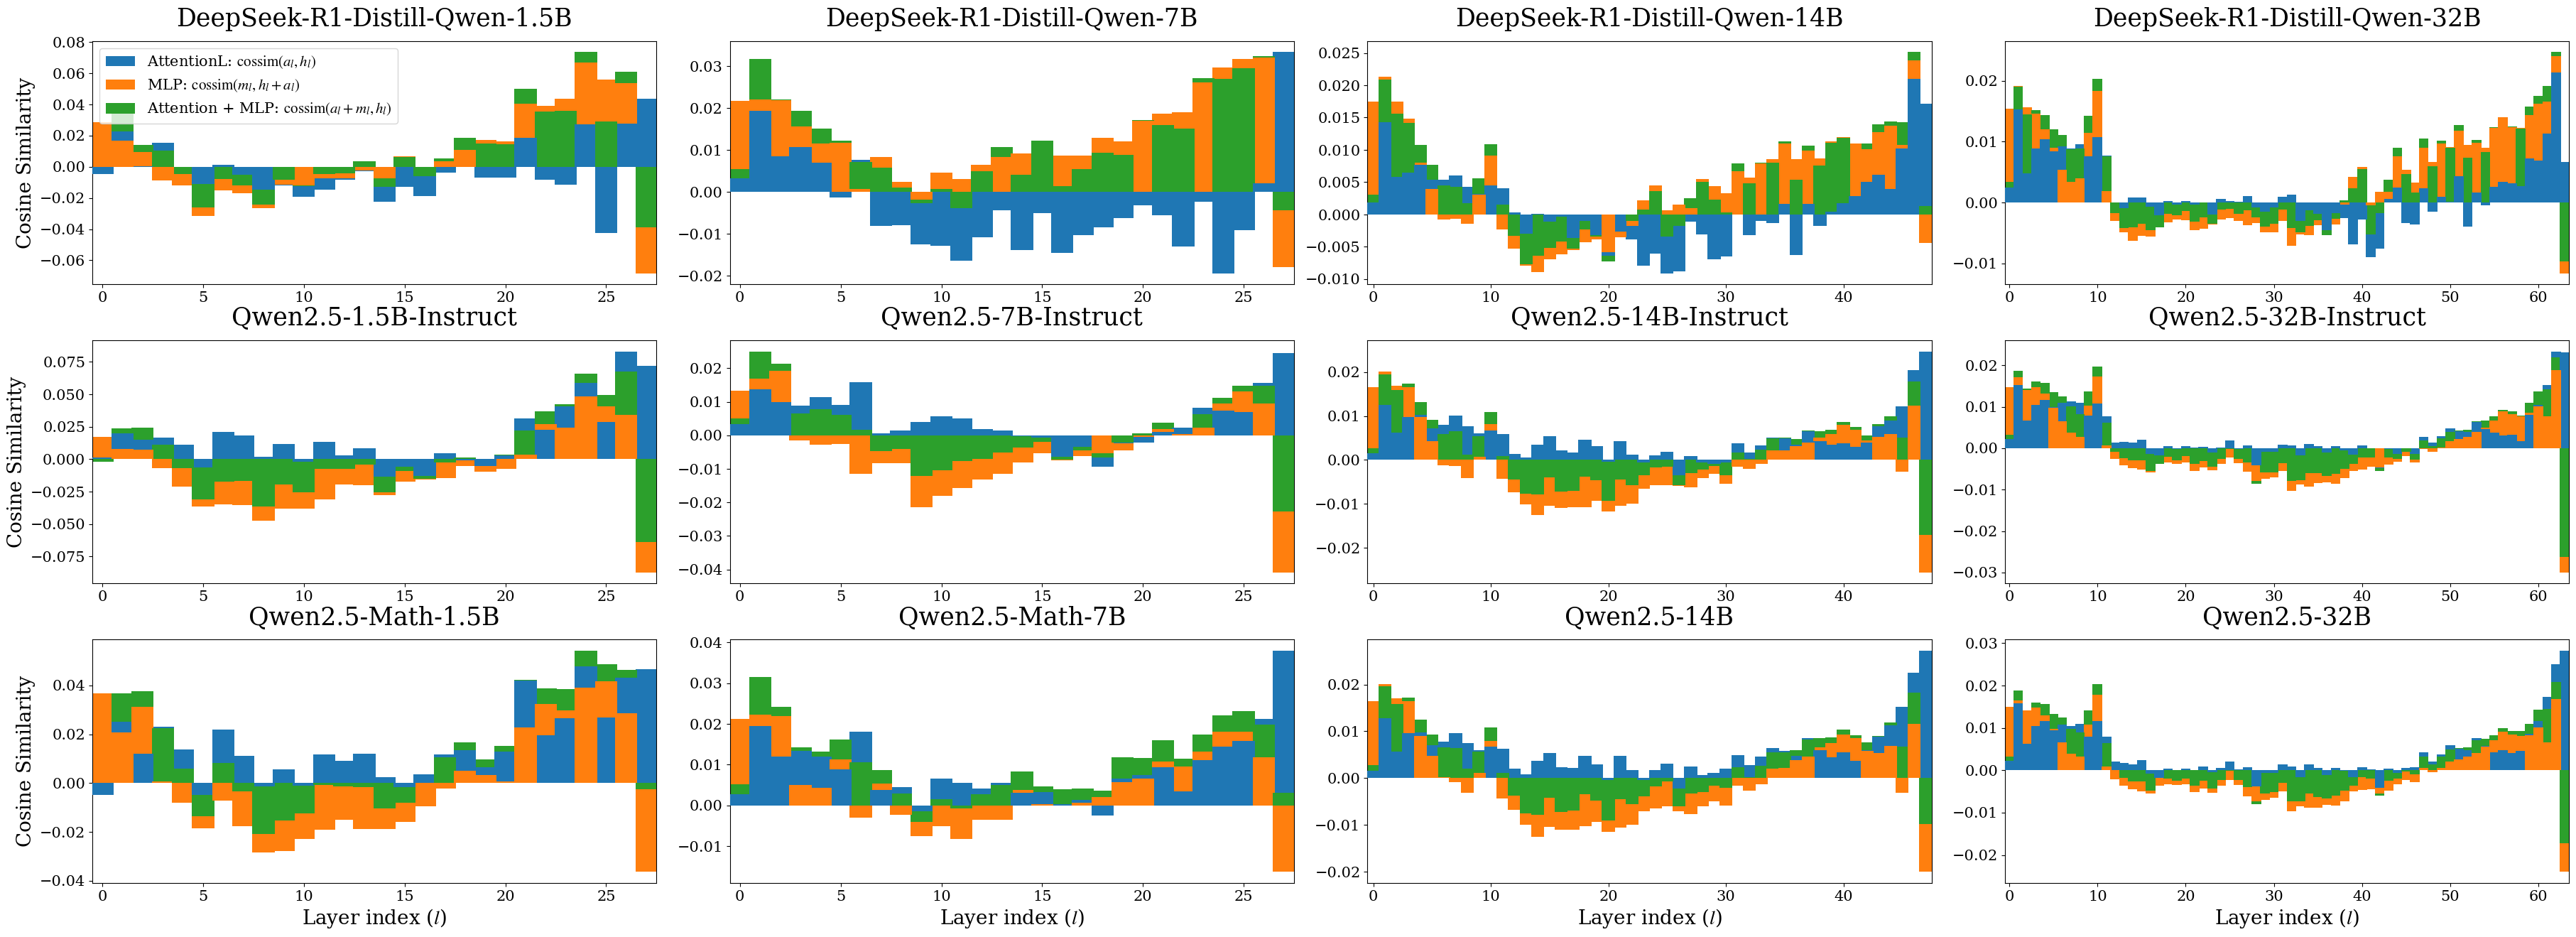

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(45, 15))

# Adjust spacing parameters - these are the key changes
plt.subplots_adjust(
    top=0.9,    # 90% of the figure height for content (leaves space for suptitle)
    hspace=0.23,  # Increased vertical space between subplots
    wspace=0.13   # Horizontal space between subplots
)

for idx, model in enumerate(models):
    # load data
    model_path = f"outputs/{task}/{model}/relative_contribution.pt"
    data = torch.load(model_path)
    att_cos = data["att_cos"]
    mlp_cos = data["mlp_cos"]
    layer_cos = data["layer_cos"]
    
    # Get the current subplot axis
    ax = axes[idx//4, idx%4]
    
    # Plot the bars
    bars = []
    bars.append(ax.bar(range(len(att_cos)), att_cos.float().cpu().numpy(), label="AttentionL: $\\text{cossim}(a_l, h_l)$", width=1.1))
    bars.append(ax.bar(range(len(mlp_cos)), mlp_cos.float().cpu().numpy(), label="MLP: $\\text{cossim}(m_l, h_l + a_l)$", width=1.1))
    bars.append(ax.bar(range(len(layer_cos)), layer_cos.float().cpu().numpy(), label="Attention + MLP: $\\text{cossim}(a_l + m_l, h_l)$", width=1.1))

    # Sort z-order
    for group in zip(*[container for container in bars]):
        z = len(group)
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1
    
    # Set subplot title and labels
    ax.set_title(model, pad=15, fontsize=25)  # Added pad to subplot titles
    ax.set_xlim(-0.5, len(att_cos)-0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)
    # ax.set_xticklabels(fontsize=15)
    # ax.set_yticklabels(fontsize=15)
    
    if idx// 4 == 2:  # Last row
        ax.set_xlabel("Layer index ($l$)", fontsize=20)
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Cosine Similarity", fontsize=20)

    # Only show legend for the first subplot to avoid repetition
    if idx == 0:
        ax.legend(fontsize=15, loc="upper left")

# set title for the entire figure
# fig.suptitle("Relative Norm Contribution", fontweight='bold', fontsize=28, y=0.98)  # Adjusted y position
fig.savefig("figures/gsm8k_relative_cossim_all_models.pdf", bbox_inches='tight', dpi=300)

## 2. The effects of the layer on future computations

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

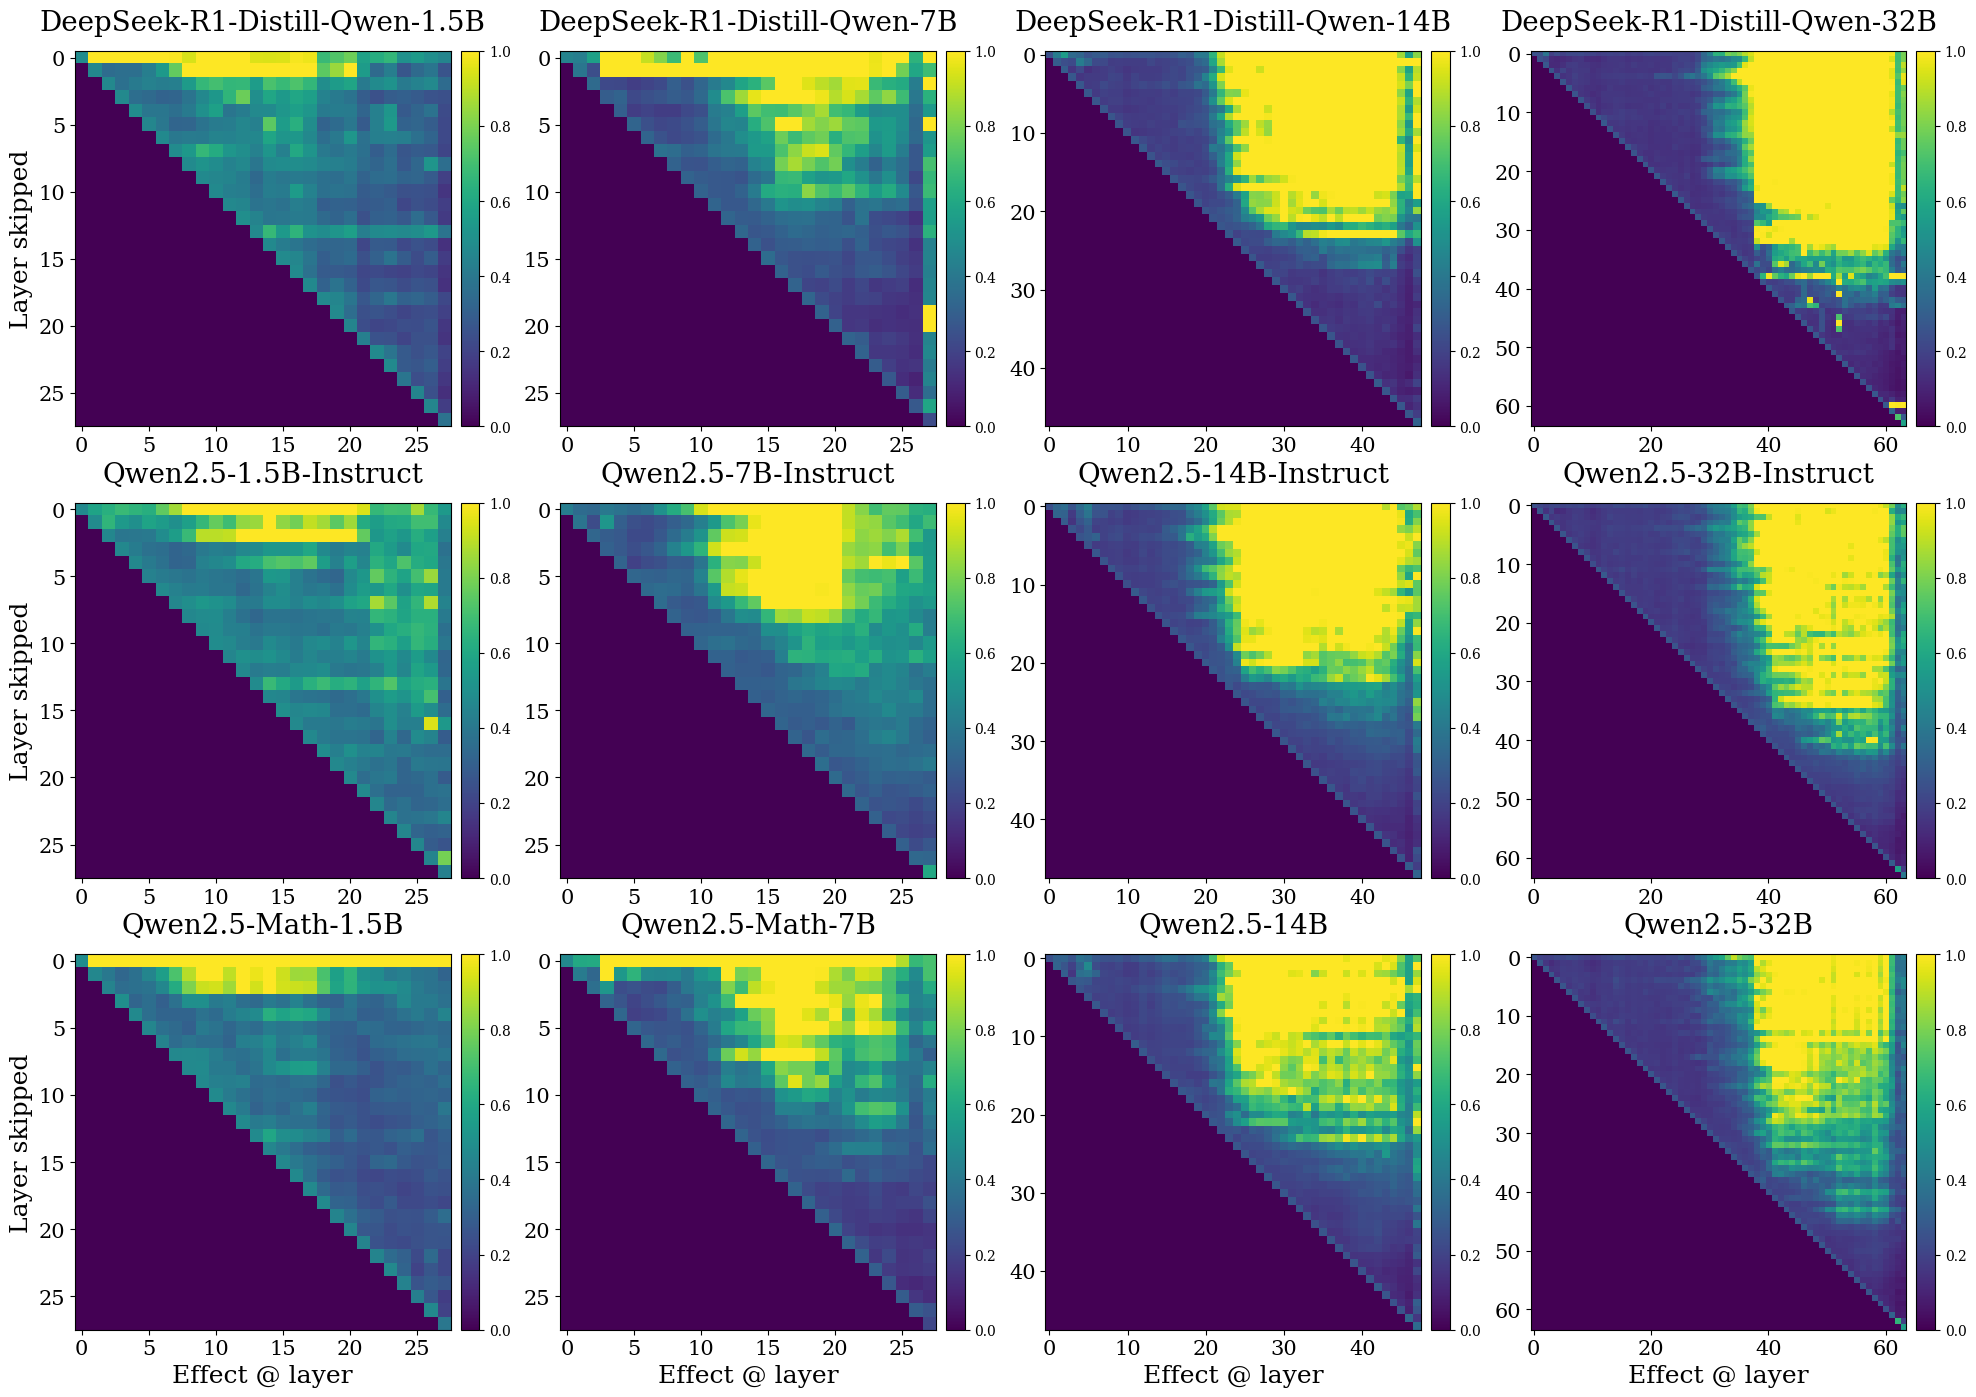

In [57]:
# Create figure for layer effects
fig_layer, axes_layer = plt.subplots(3, 4, figsize=(24, 16))
plt.subplots_adjust(
    top=0.92,
    hspace=0.15,
    wspace=0.2  # Increased for colorbar spacing
)

for idx, model in enumerate(models):
    # Load data
    model_path = f"outputs/{task}/{model}/layer_effects_10exps.pt"
    data = torch.load(model_path)
    max_future_layer = torch.max(torch.zeros([1]), data["max_future_layer"])
    
    ax = axes_layer[idx//4, idx%4]
    
    # Plot heatmap
    im = ax.imshow(max_future_layer.float().cpu().numpy(), 
                  vmin=0, vmax=1, 
                  interpolation="nearest")
    
    # Add colorbar to each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig_layer.colorbar(im, cax=cax)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_title(model, fontsize=20, pad=15)  # Added pad to subplot titles
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Layer skipped", fontsize=18)
    if idx // 4 == 2:  # Last row
        ax.set_xlabel("Effect @ layer", fontsize=18)

# fig_layer.suptitle("Layer Effects Across Models", fontsize=20, y=0.98)
fig_layer.savefig("figures/gsm8k_layer_effects_all_models.pdf", bbox_inches='tight', dpi=300)

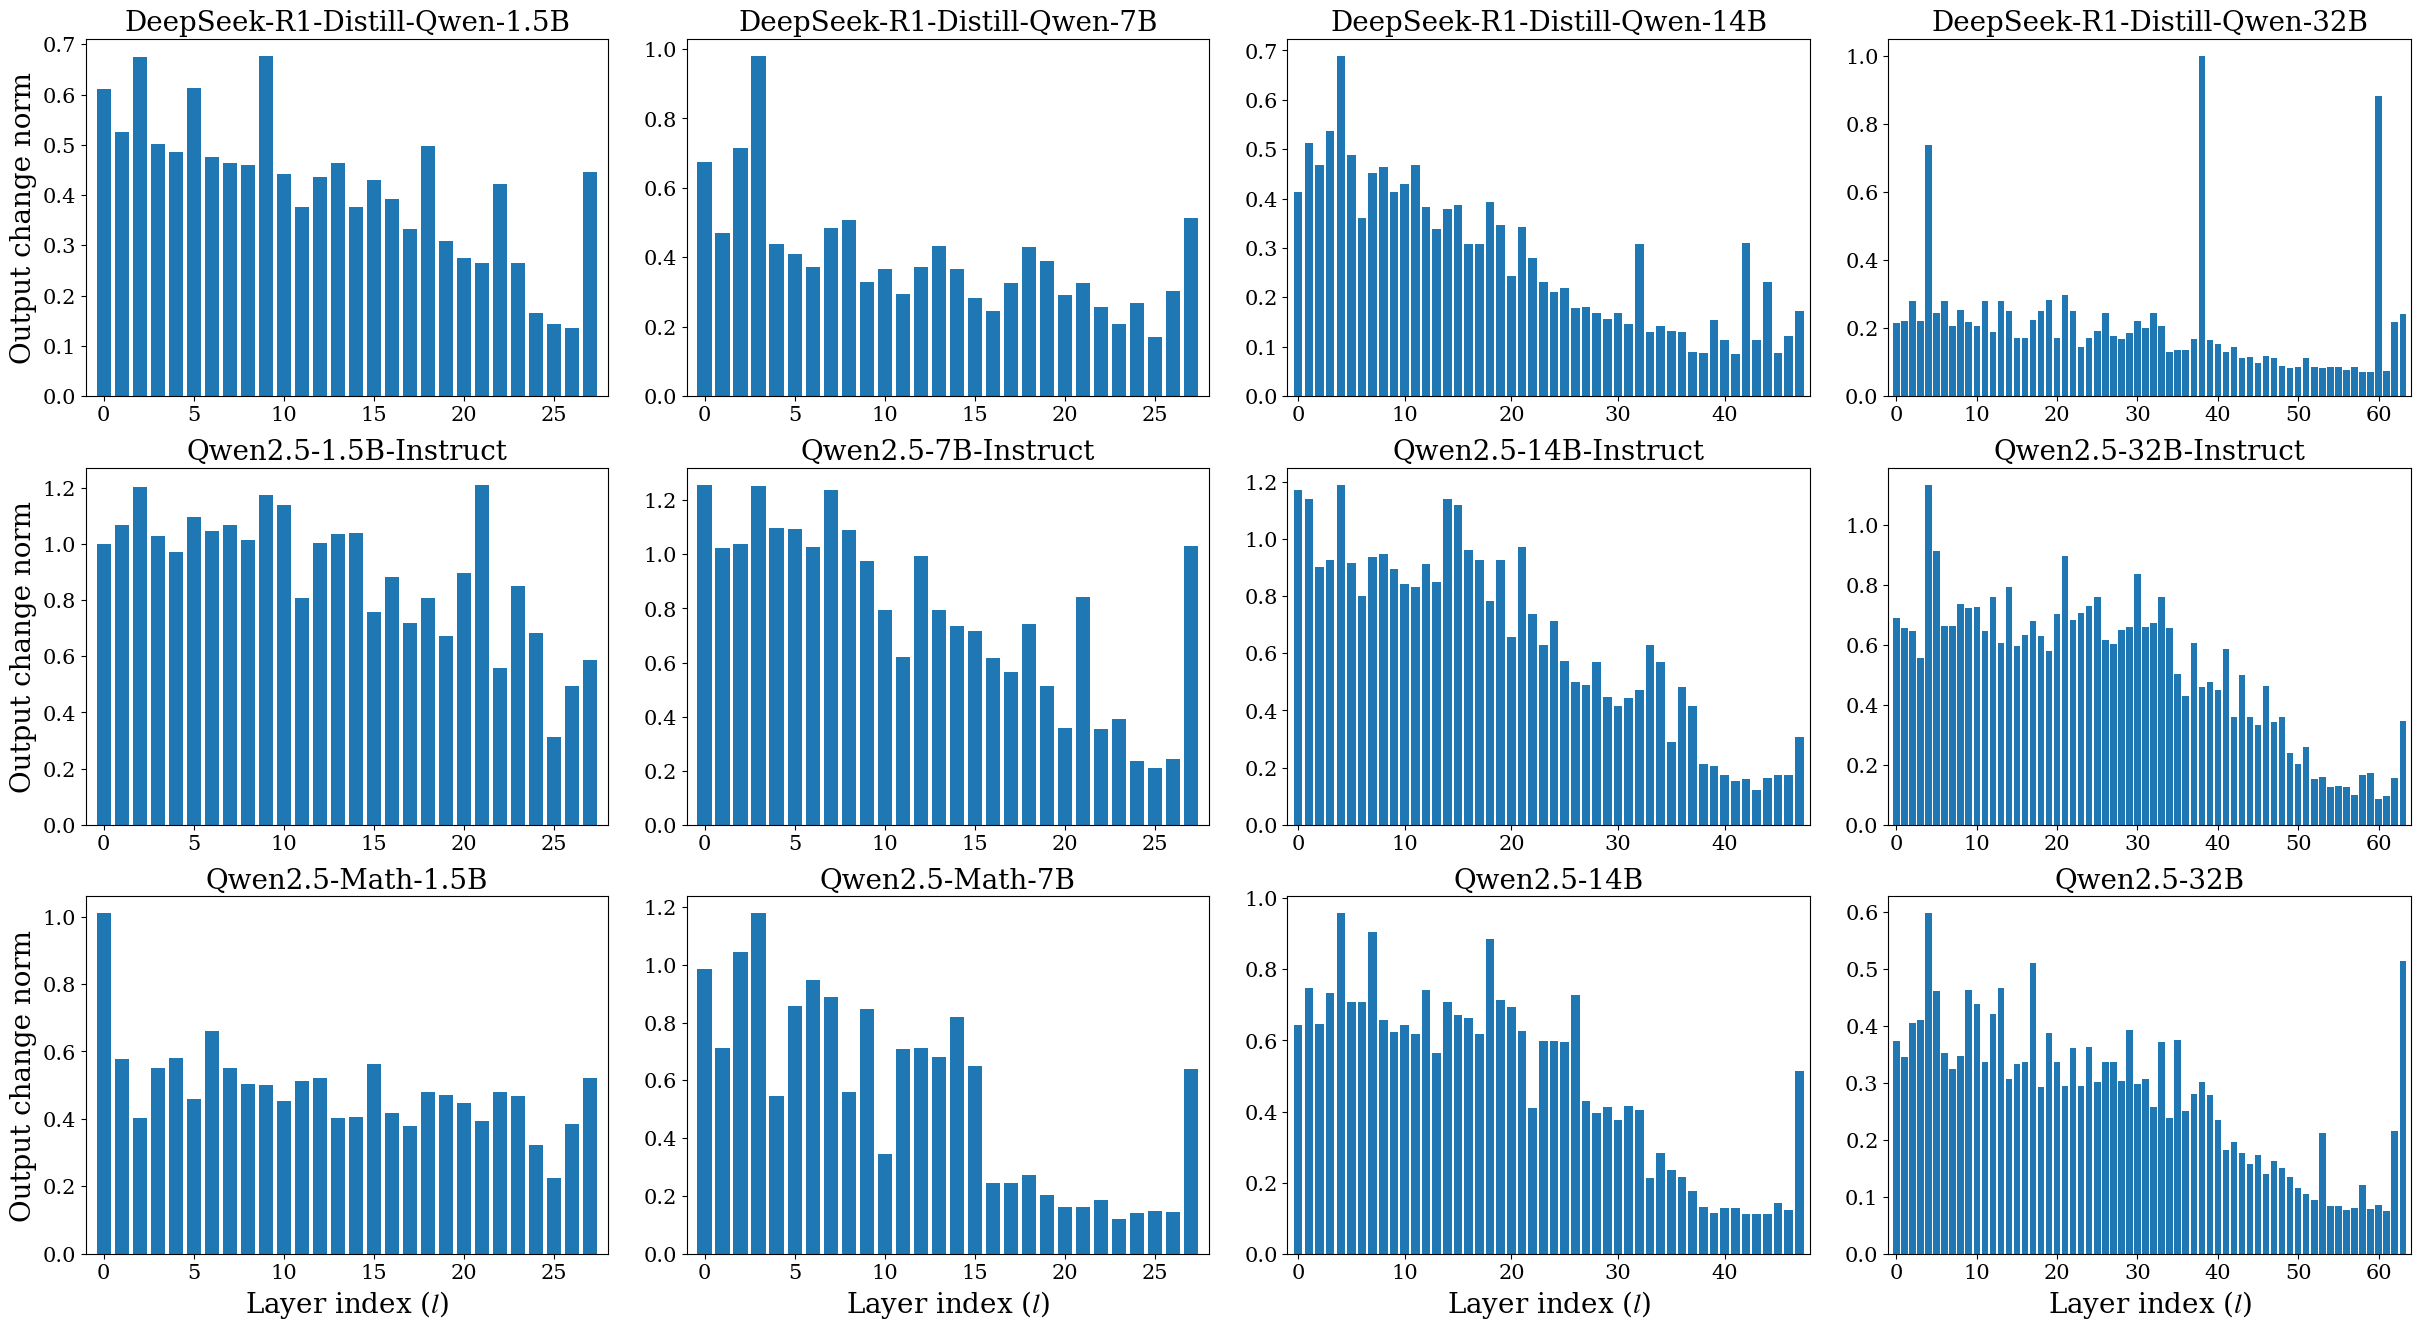

In [53]:
fig_out, axes_out = plt.subplots(3, 4, figsize=(30, 15))
plt.subplots_adjust(
    top=0.92,
    hspace=0.2,
    wspace=0.15
)

for idx, model in enumerate(models):
    # Load data
    model_path = f"outputs/{task}/{model}/layer_effects_10exps.pt"
    data = torch.load(model_path)
    max_future_out = data["max_future_out"].squeeze()
    
    ax = axes_out[idx//4, idx%4]
    
    # Plot bar chart
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.bar(range(len(max_future_out)), max_future_out.float().cpu().numpy())
    ax.set_xlim(-1, len(max_future_out))
    ax.set_title(model, fontsize=20)
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Output change norm", fontsize=20)
    if idx // 4 == 2:  # Last row
        ax.set_xlabel("Layer index ($l$)", fontsize=20)

# fig_out.suptitle("Output Changes Across Models", fontsize=20, y=0.98)
# plt.show()
plt.savefig("figures/gsm8k_layer_effects_output_changes_all_models.pdf", bbox_inches='tight', dpi=300)

## 3. Logit lens

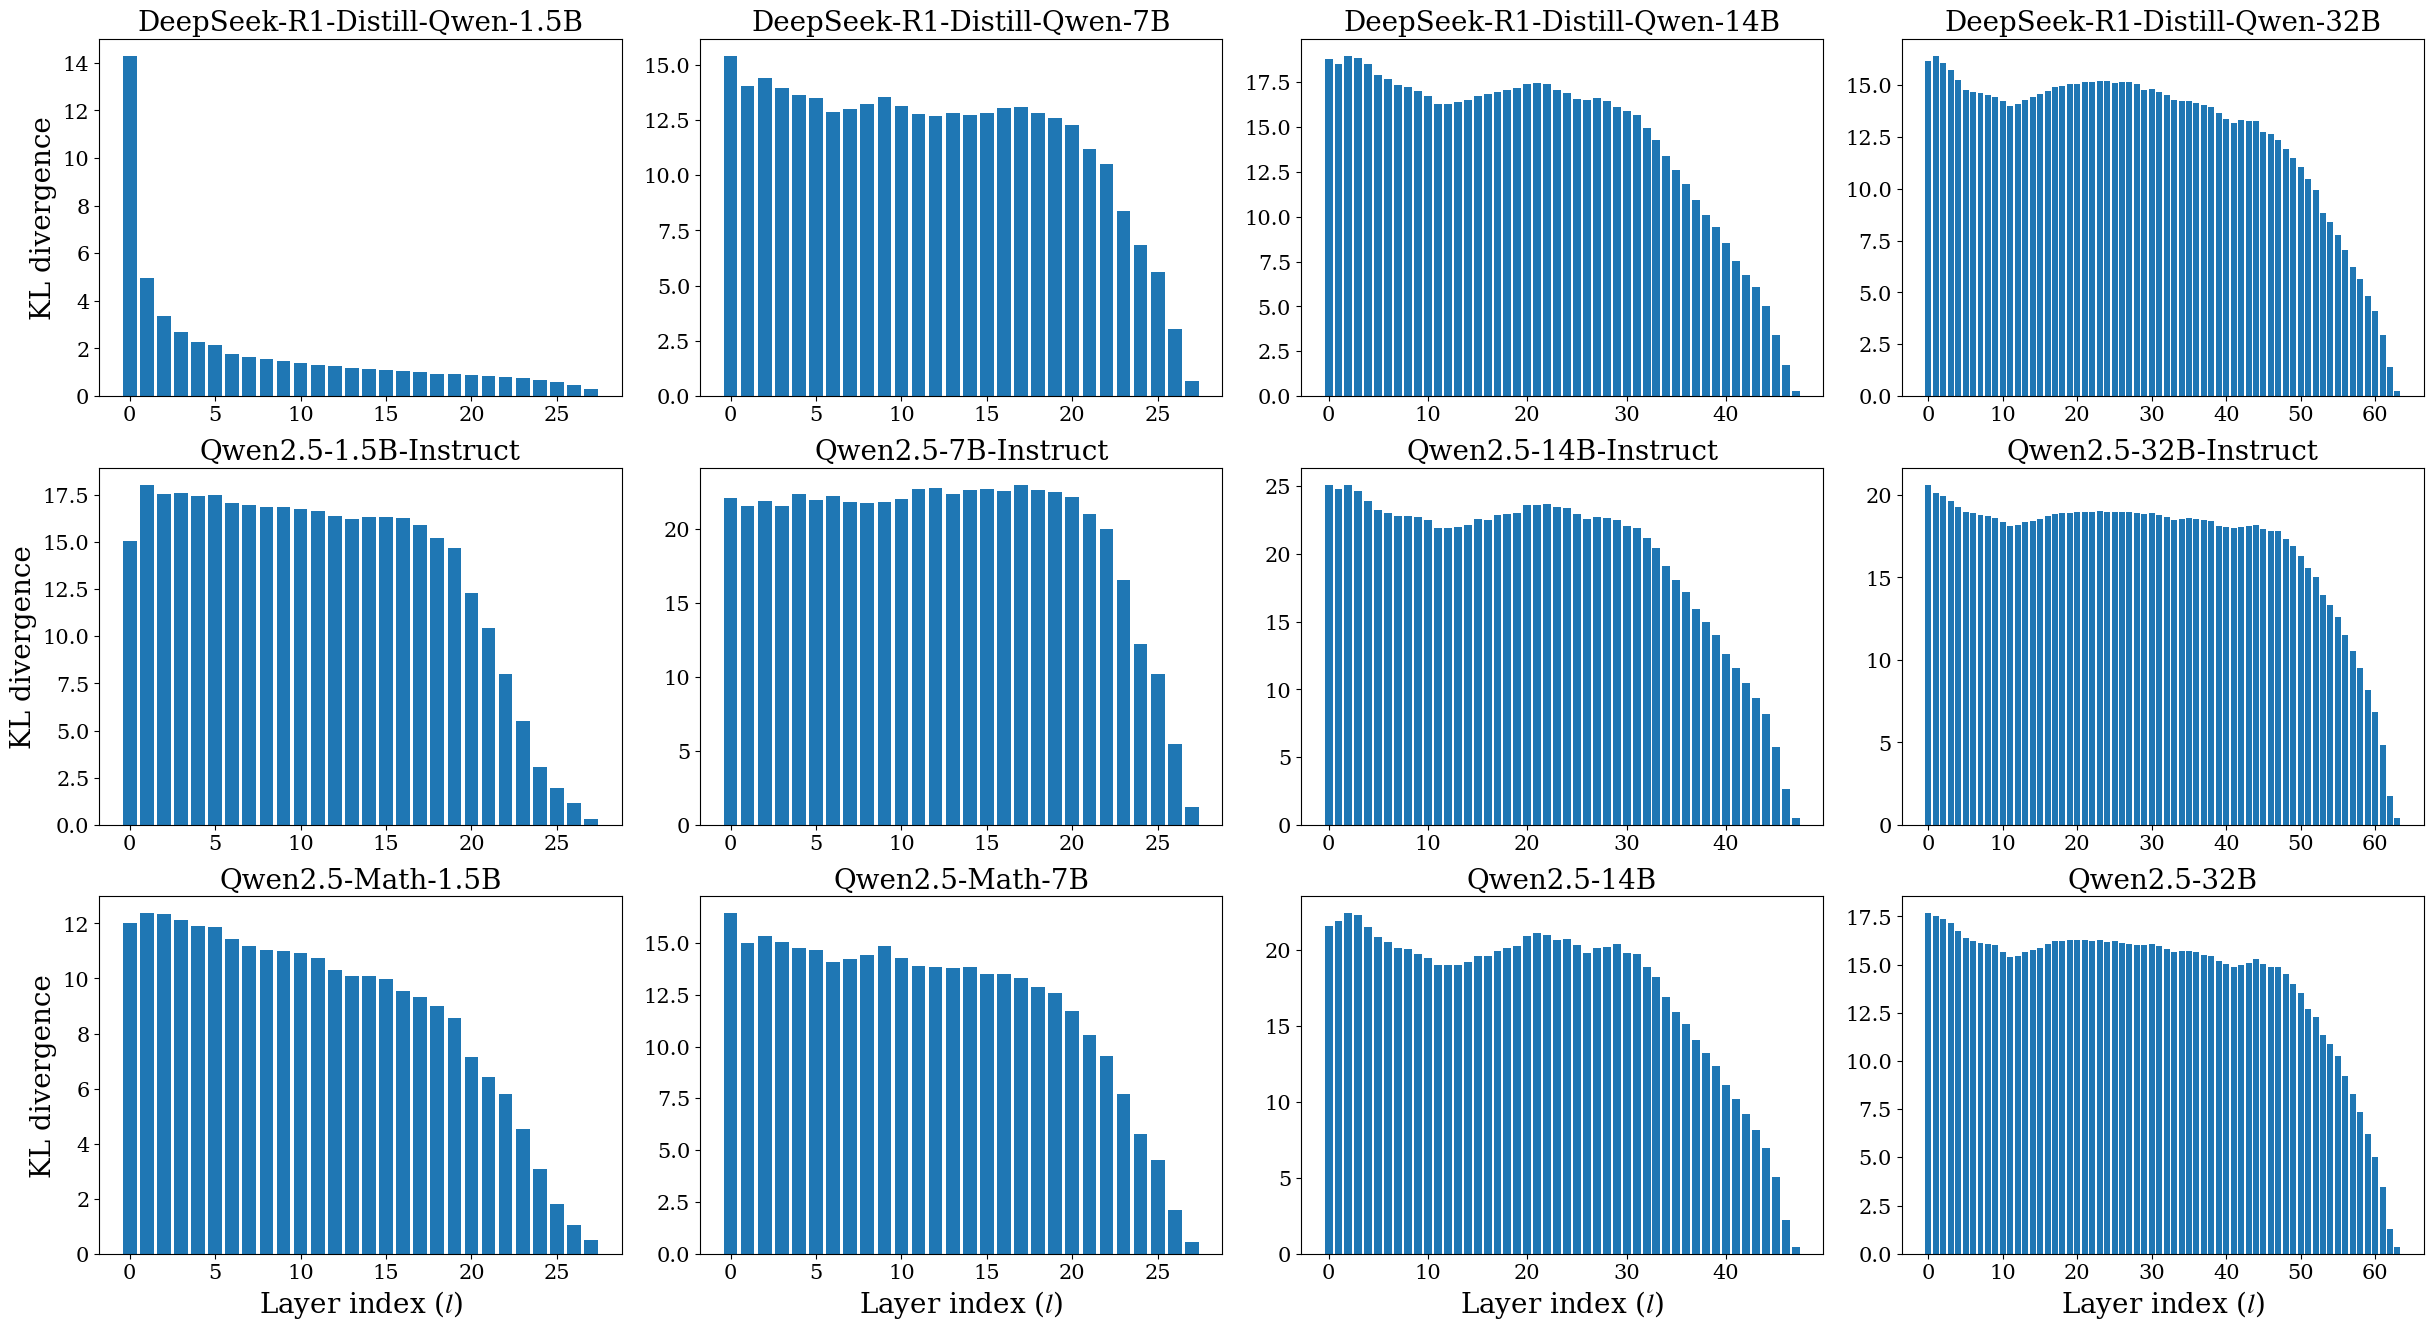

In [58]:
fig_kl, axes_kl = plt.subplots(3, 4, figsize=(30, 15))
plt.subplots_adjust(
    top=0.92,
    hspace=0.2,
    wspace=0.15
)

for idx, model in enumerate(models):
    # Load data
    try:
        model_path = f"outputs/{task}/{model}/logitlens_10exps.pt"
        data = torch.load(model_path)
        res_kl_divs = data["res_kl_divs"]

        ax = axes_kl[idx//4, idx%4]

    except Exception as e:
        print(f"Error loading {model}: {e}")
        continue

    # Plot bar chart
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.bar(range(len(res_kl_divs)), res_kl_divs.float().cpu().numpy())
    ax.set_title(model, fontsize=20)
    if idx // 4 == 2:  # Last row
        ax.set_xlabel("Layer index ($l$)", fontsize=20)
    if idx % 4 == 0:  # First column
        ax.set_ylabel("KL divergence", fontsize=20)

# fig_kl.suptitle("Logit Lens Across Models", fontsize=20, y=0.98)
fig_kl.savefig("figures/gsm8k_logit_lens_kl_all_models.pdf", bbox_inches='tight', dpi=300)

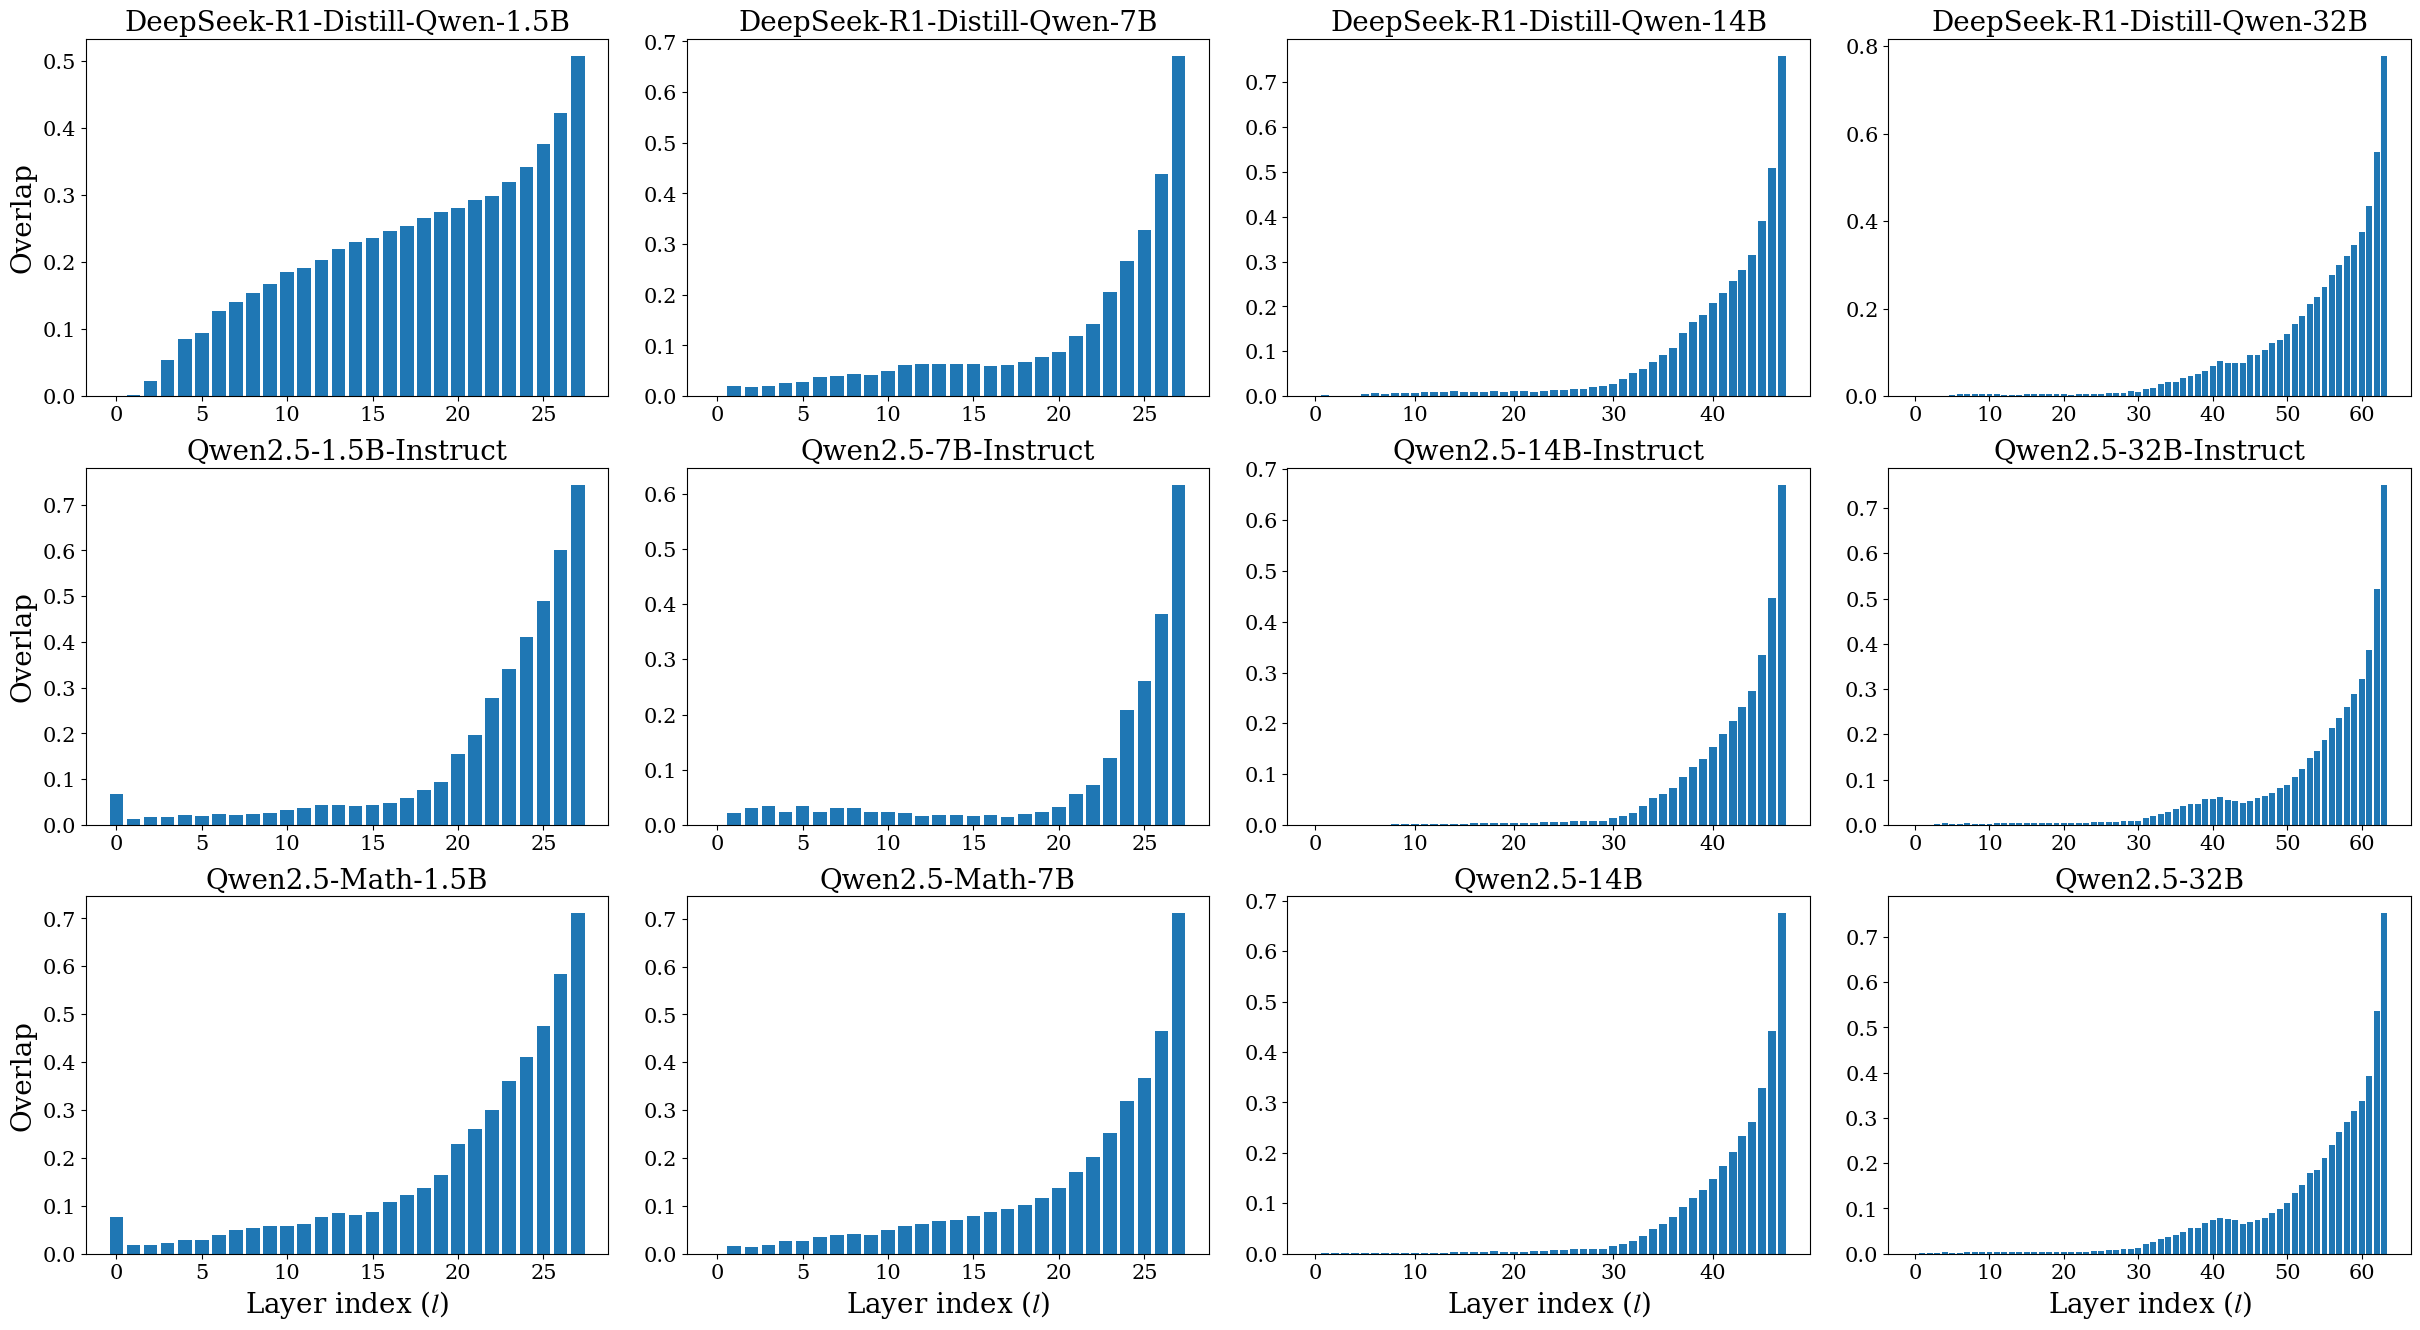

In [59]:
fig_ol, axes_ol = plt.subplots(3, 4, figsize=(30, 15))
plt.subplots_adjust(
    top=0.92,
    hspace=0.2,
    wspace=0.15
)

for idx, model in enumerate(models):
    # Load data

    model_path = f"outputs/{task}/{model}/logitlens_10exps.pt"
    data = torch.load(model_path)
    res_overlaps = data["res_overlaps"]

    ax = axes_ol[idx//4, idx%4]

    ax.tick_params(axis='both', which='major', labelsize=15)
    # Plot bar chart
    ax.bar(range(len(res_overlaps)), res_overlaps.float().cpu().numpy())
    ax.set_title(model, fontsize=20)
    if idx // 4 == 2:  # Last row
        ax.set_xlabel("Layer index ($l$)", fontsize=20)
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Overlap", fontsize=20)


# fig_ol.suptitle("Logit Lens Overlap Across Models", fontsize=20, y=0.98)
fig_ol.savefig("figures/gsm8k_logit_lens_overlap_all_models.pdf", bbox_inches='tight', dpi=300)

## 4. residual erasure experiment

/tmp/ipykernel_868355/1482482814.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 2400x1600 with 24 Axes> than <Figure size 2000x2400 with 13 Axes> which fig.colorbar is called on.
  cbar = fig_re.colorbar(im, cax=cax)
/tmp/ipykernel_868355/1482482814.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 2400x1600 with 24 Axes> than <Figure size 2000x2400 with 14 Axes> which fig.colorbar is called on.
  cbar = fig_re.colorbar(im, cax=cax)
/tmp/ipykernel_868355/1482482814.py:35: UserWarning: Adding colorbar to a different Figure <Figure size 2400x1600 with 24 Axes> than <Figure size 2000x2400 with 15 Axes> which fig.colorbar is called on.
  cbar = fig_re.colorbar(im, cax=cax)
/tmp/ipykernel_868355/1482482814.py:32: UserWarning: Adding colorbar to a different Figure <Figure size 2400x1600 with 24 Axes> than <Figure size 2000x2400 with 16 Axes> which fig.colorbar is called on.
  cbar = fig_re.colorbar(im, cax=cax)
/tmp/ipykernel_868355/1482482814.py:

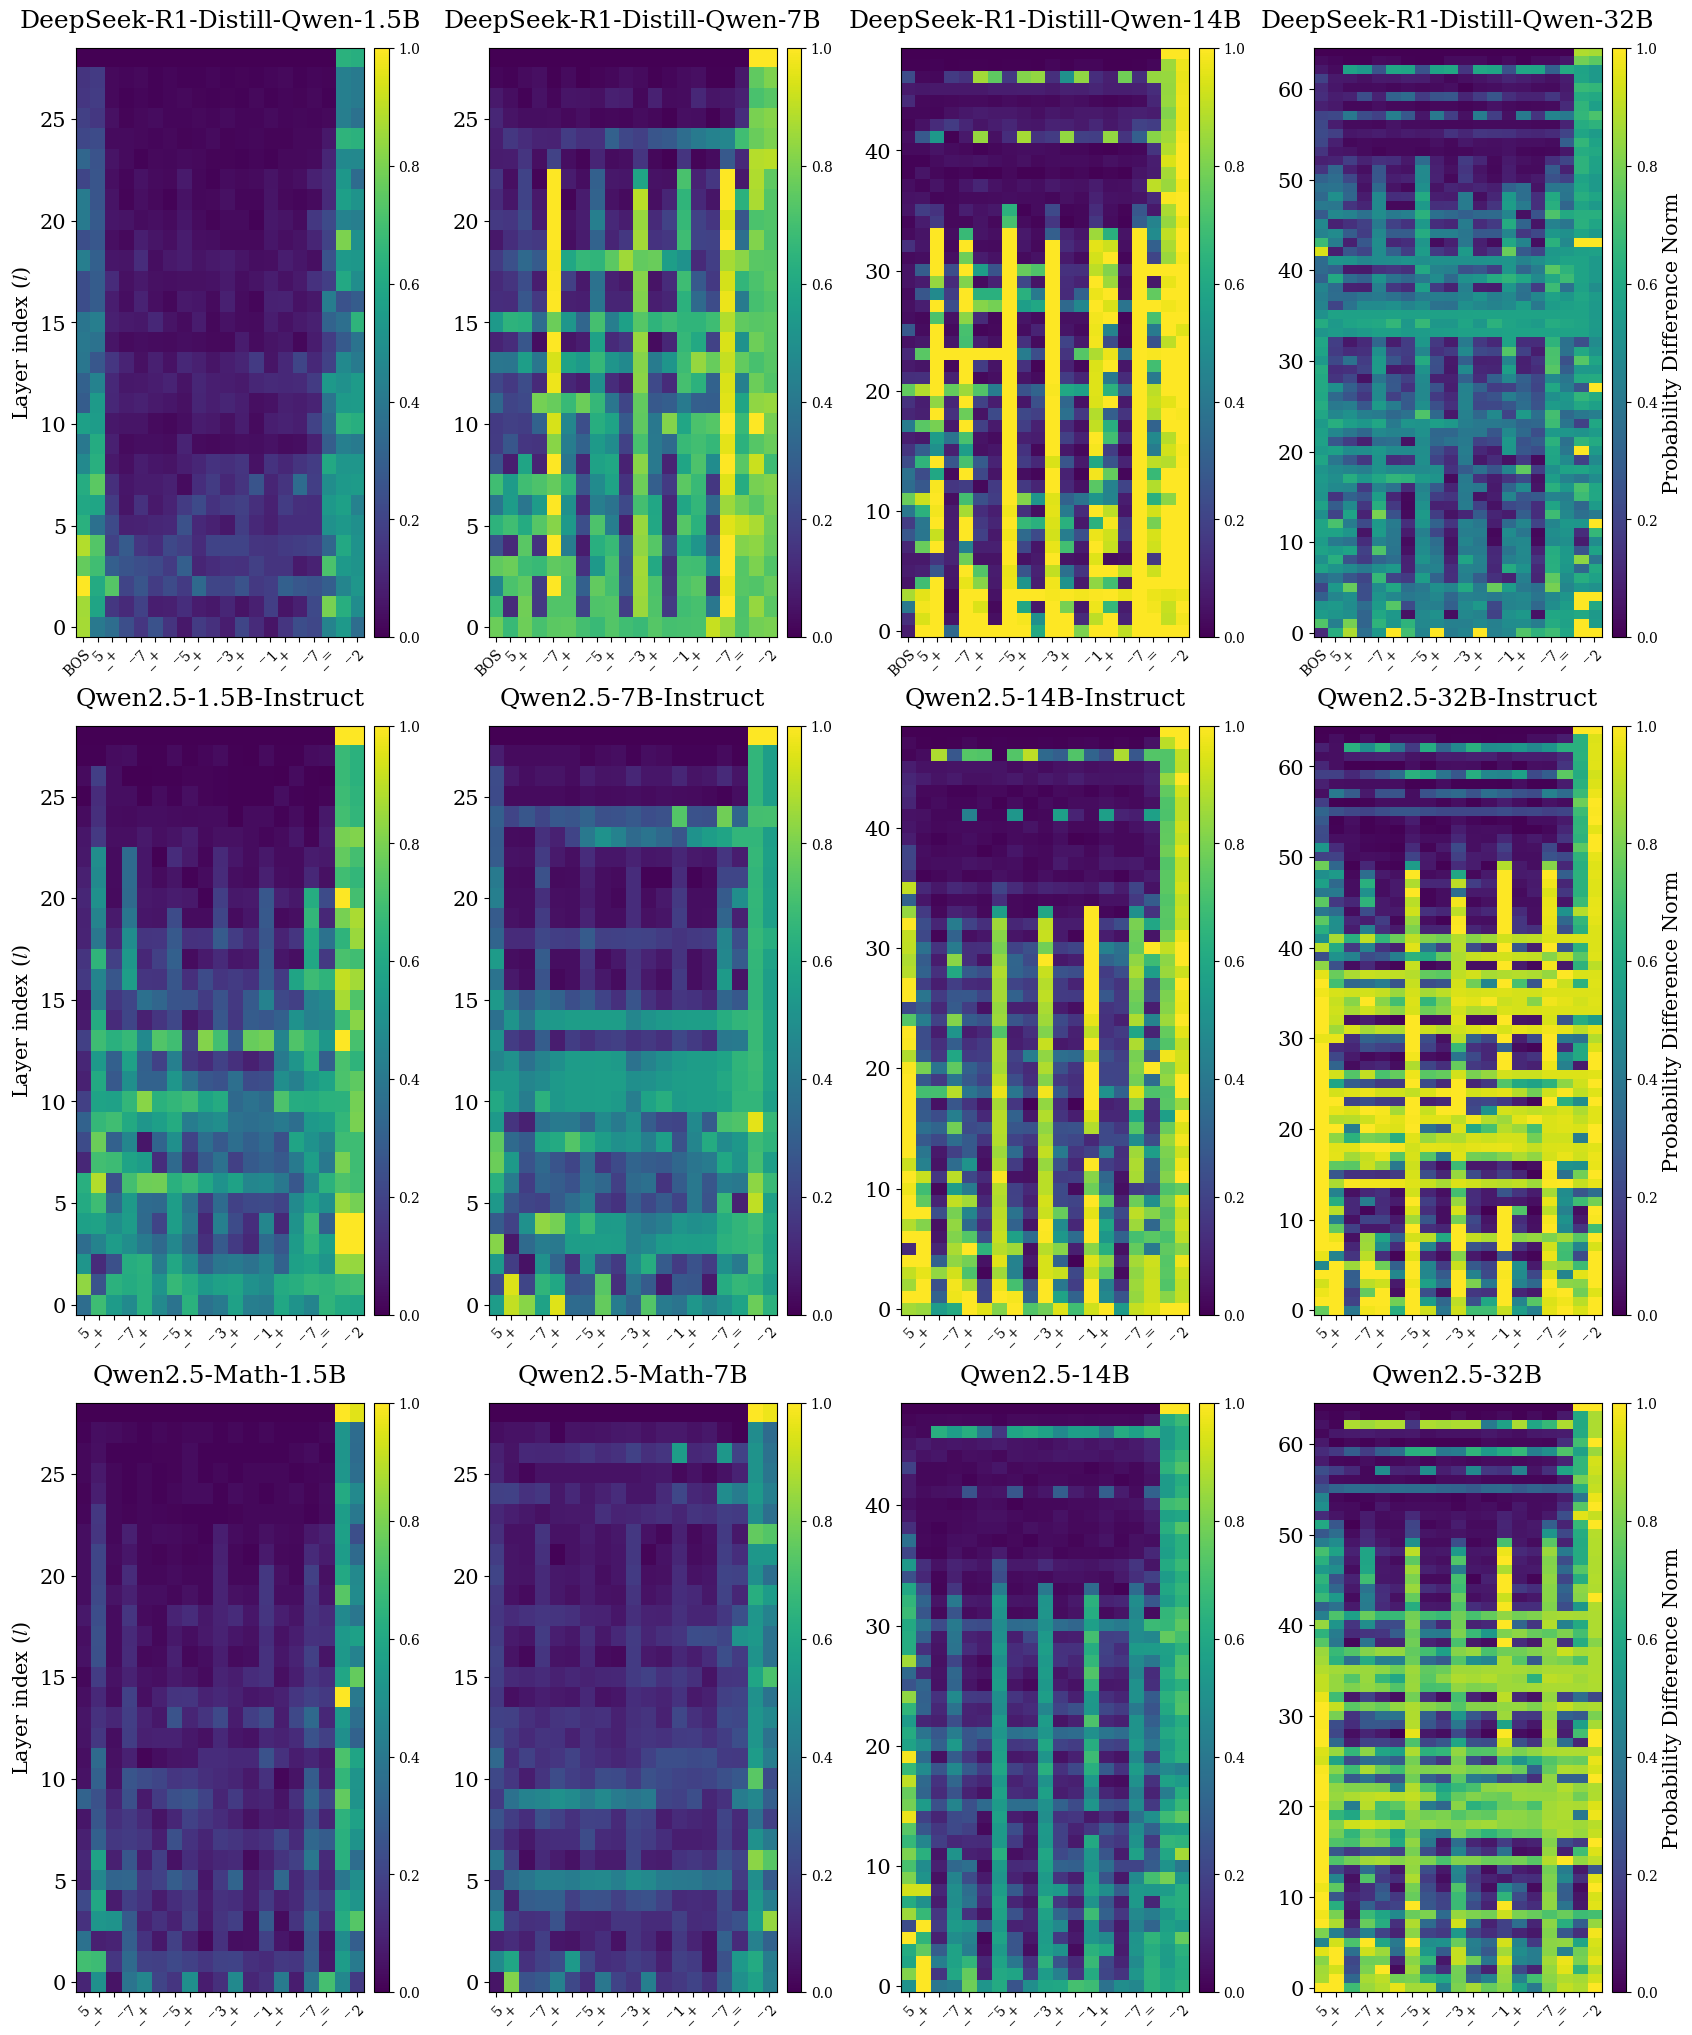

In [70]:
fig_re, axes_re = plt.subplots(3, 4, figsize=(20, 24))
plt.subplots_adjust(
    top=0.92,
    hspace=0.15,
    wspace=0.32
)


for idx, model in enumerate(models):
    # Load data
    model_path = f"outputs/{task}/{model}/logit_erasure_10exps.pt"
    data = torch.load(model_path)
    erasure_effect = data["erasure_effect"]

    ax = axes_re[idx//4, idx%4]

    
    ls = erasure_effect[:, :-1]
    with open(f"outputs/{task}/{model}/logit_erasure_tokens_10exps.txt") as f: 
        tokens = f.read().splitlines()
    tokens = tokens[:-1]
    tokens = [t if t != "<｜begin▁of▁sentence｜>" else "BOS" for t in tokens]
    
    ax.imshow(ls.float().cpu().numpy(), 
              aspect='auto', cmap='viridis', 
              vmin=0, vmax=1
              )
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if idx % 4 == 3:  # Last column
        cbar = fig_re.colorbar(im, cax=cax)
        cbar.set_label('Probability Difference Norm', size=15)
    else:
        cbar = fig_re.colorbar(im, cax=cax)
    
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Layer index ($l$)", fontsize=15)

    # Configure ticks and labels
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', rotation_mode="anchor", fontsize=10)
    ax.invert_yaxis()
    ax.set_title(model, pad=15, fontsize=18)


# fig_re.suptitle("Residual Erasure Effect Across Models", fontsize=20, y=0.98)
fig_re.savefig("figures/gsm8k_logit_erasure_all_models.pdf", bbox_inches='tight', dpi=300)

## 5. integrated gradients

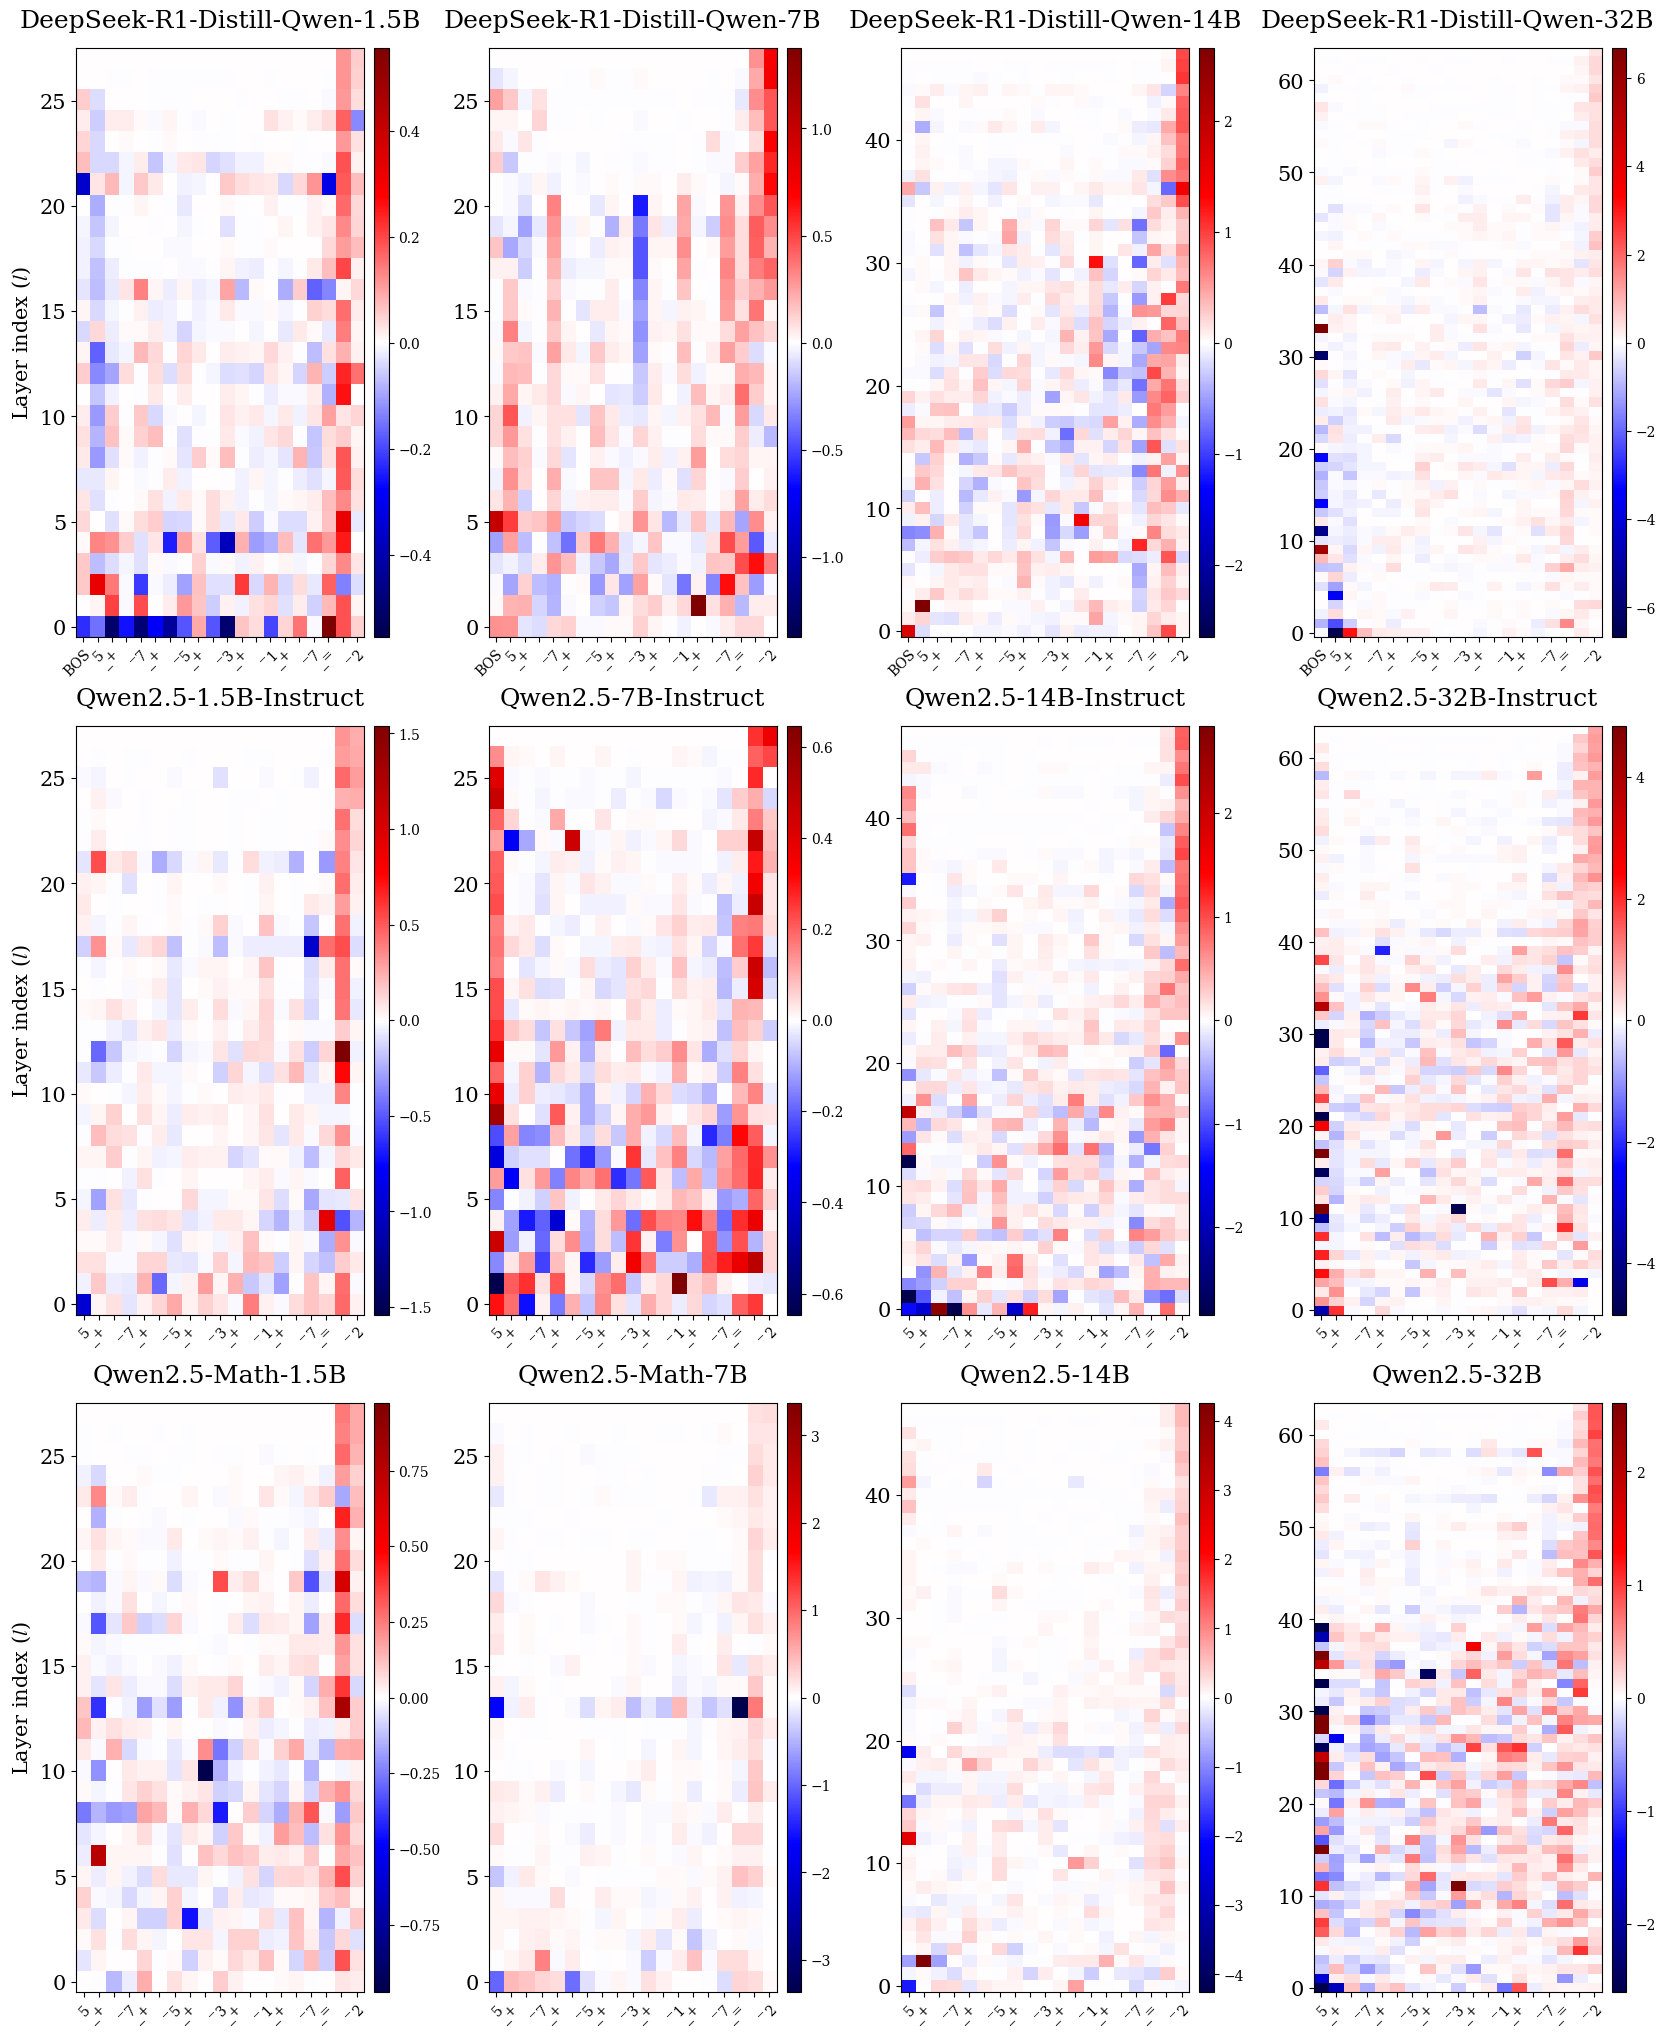

In [72]:
fig_ig, axes_ig = plt.subplots(3, 4, figsize=(20, 24))
plt.subplots_adjust(
    top=0.92,
    hspace=0.15,
    wspace=0.32
)

for idx, model in enumerate(models):
    ax = axes_ig[idx//4, idx%4]

    # Load model data
    model_path = f"outputs/{task}/{model}/igrads_igrads_10exps.pt"
    data = torch.load(model_path)
    igrads = data["igrads"]
    
    # Load tokens
    with open(f"outputs/{task}/{model}/igrads_tokens_10exps.txt") as f:
        tokens = f.read().splitlines()
    tokens = [t if t != "<｜begin▁of▁sentence｜>" else "BOS" for t in tokens]
    
    # Remove BOS token and calculate symmetric range
    r = igrads[:, 1:].abs().max().item()
    
    # Plot heatmap
    im = ax.imshow(igrads[:, :-1].float().cpu().numpy(), 
                    cmap="seismic", 
                    vmin=-r, 
                    vmax=r, 
                    interpolation="nearest",
                    aspect='auto')
    
    ax.tick_params(axis='both', which='major', labelsize=15)

    ax.set_xticks(range(len(tokens)-1))
    ax.set_xticklabels(tokens[:-1], rotation=45, ha='right', rotation_mode="anchor", fontsize=10)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    
    ax.set_title(model, pad=15, fontsize=18)
    if idx % 4 == 0:  # First column
        ax.set_ylabel("Layer index ($l$)", fontsize=15)
    ax.invert_yaxis()

# fig_ig.suptitle("Integrated Gradients Across Models", fontsize=20, y=0.98)
fig_ig.savefig("figures/gsm8k_igrads_all_models.pdf", bbox_inches='tight', dpi=300)

In [ ]:
def count_metric(lout: torch.Tensor, llayer: torch.Tensor, k_list: list = [1, 3, 5, 10]) -> float:
    '''
    calculate Mean Reciprocal Rank (MRR) and Hits@k for each layer
    '''
    # lout: [btz, seq_len, vocab_size]
    # llayer: [btz, seq_len, vocab_size]
    metrics = {}
    
    # batch_size is always 1 in this case
    target = lout[0].topk(1, dim=-1).indices
    
    rank = (llayer[0].argsort(dim=-1, descending=True) == target).nonzero()[:, 1] # seq_len
    rank = rank + 1
    mrr = (1 / (rank)).mean()
    metrics["mrr"] = mrr.item()
    
    for k in k_list:
        hits_at_k = (rank <= k).float().mean()
        metrics[f"hits@{k}"] = hits_at_k.item()

    return metrics